In [49]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

In [51]:
df = pd.read_csv("GitHub_Projects.csv")
updated = pd.to_datetime(df["updated_at"]).dt.date
created = pd.to_datetime(df["created_at"]).dt.date
days = updated-created
days = pd.to_numeric(days.dt.days, downcast='integer')
df["updated-created"] = days 
data = df[["repo_name", "Description", "stargazers_count", "forks_count", "num_model_file", "updated-created"]]
data.head()

,repo_name,Description,stargazers_count,forks_count,num_model_file,updated-created
0,ECAN_dspic,An ECAN library for the dsPIC33f in both C and...,0,7,3,2459
1,truetime,TrueTime is a Matlab/Simulink-based simulator ...,4,18,22,3085
2,launchpad_ert,Simulink (Embedded Coder) Target for TI LaunchPad,7,5,11,2684
3,osx-sl-joystick,Access Joysticks in Simulink on OSX,1,0,1,545
4,simulink-rtl-sdr,An Open Source Software Package that enables o...,27,17,2,2415


In [52]:
data1 = data[["stargazers_count", "forks_count", "num_model_file", "updated-created"]]
# data.to_csv("numerical_cluster.csv")

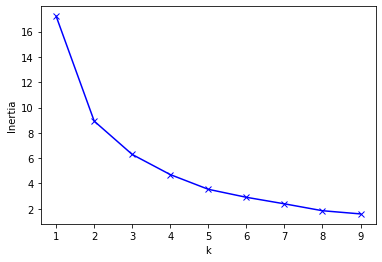

In [53]:
#inspired from https://www.kaggle.com/ellecf/visualizing-multidimensional-clusters
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(data1)
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_normal)
    kmeanModel.fit(features_normal)
    inertia.append(kmeanModel.inertia_)
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [56]:
#from the above elbow method we got the number of clusters to be 2 as the elbow is forming at k=2
kmeans = KMeans(n_clusters=2).fit(features_normal)
labels = pd.DataFrame(kmeans.labels_)
df["numeric_cluster"] = labels
onlynumericclusters = pd.concat((data1,labels),axis=1)
onlynumericclusters = onlynumericclusters.rename({0:'labels'},axis=1)
onlynumericclusters.head()

,stargazers_count,forks_count,num_model_file,updated-created,labels
0,0,7,3,2459,1
1,4,18,22,3085,1
2,7,5,11,2684,1
3,1,0,1,545,0
4,27,17,2,2415,1


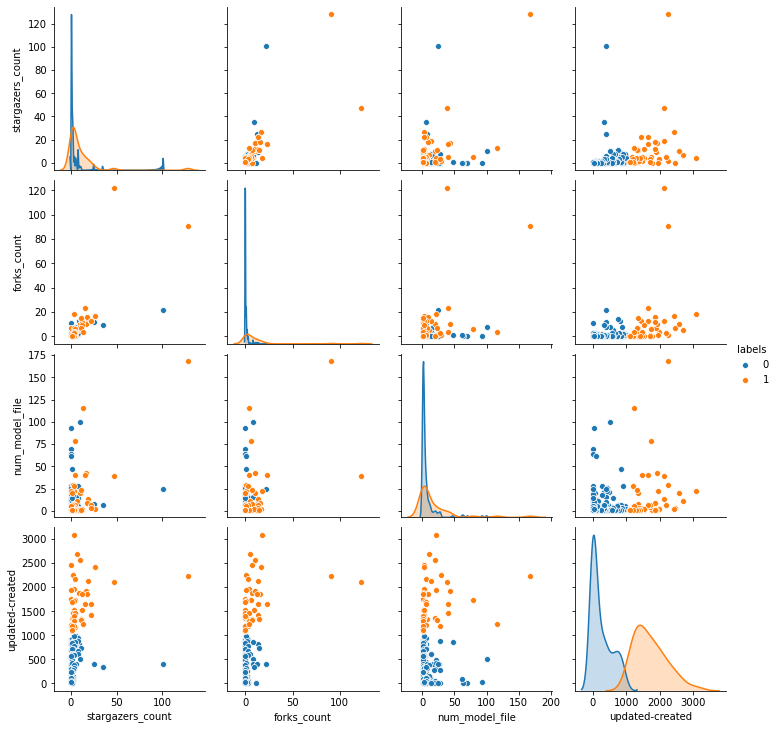

In [57]:
sns.pairplot(onlynumericclusters,hue='labels')

In [ ]:
#df.head()